In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
spark = SparkSession.builder \
    .appName("spark") \
    .master("spark://spark-master:7077")\
    .getOrCreate()

# spark.stop()

2. Reading the Data

In [2]:
# Path to the input data
data_path = "hdfs://namenode:9000/home_credit/data/"

# Reading each CSV file into a Spark DataFrame
data_app_train = spark.read.csv(data_path + "application_train.csv", header=True, inferSchema=True)
data_app_test = spark.read.csv(data_path + "application_test.csv", header=True, inferSchema=True)


In [ ]:
# Writing DataFrames to Parquet format
parquet_path = "hdfs://namenode:9000/home_credit/data_parquet/"
data_app_train.write.parquet(parquet_path + "application_train.parquet")
data_app_test.write.parquet(parquet_path + "application_test.parquet")

In [4]:
data_app_train_parquet = spark.read.parquet(parquet_path + "application_train.parquet")

In [5]:
data_app_train_parquet.show()

+----------+------+------------------+-----------+------------+---------------+------------+----------------+----------+-----------+---------------+---------------+--------------------+--------------------+--------------------+-------------------+--------------------------+----------+-------------+-----------------+---------------+-----------+----------+--------------+---------------+----------------+----------+----------+--------------------+---------------+--------------------+---------------------------+--------------------------+-----------------------+--------------------------+--------------------------+---------------------------+----------------------+----------------------+-----------------------+--------------------+------------------+-------------------+-------------------+--------------+----------------+---------------------------+------------------+--------------+-------------+-------------+-------------+-------------+------------+--------------------+-------------------+-

In [6]:
data_app_test_parquet = spark.read.parquet(parquet_path + "application_test.parquet")

In [7]:
data_app_test_parquet.show()

+----------+------------------+-----------+------------+---------------+------------+----------------+----------+-----------+---------------+---------------+--------------------+--------------------+--------------------+-------------------+--------------------------+----------+-------------+-----------------+---------------+-----------+----------+--------------+---------------+----------------+----------+----------+---------------+---------------+--------------------+---------------------------+--------------------------+-----------------------+--------------------------+--------------------------+---------------------------+----------------------+----------------------+-----------------------+--------------------+-------------------+--------------------+-------------------+--------------+----------------+---------------------------+------------------+--------------+-------------+-------------+-------------+-------------+------------+--------------------+--------------+----------------

# Kiểm tra sự phân bố của cột mục tiêu

Mục tiêu là những gì chúng tôi được yêu cầu dự đoán: số 0 cho khoản vay được hoàn trả đúng hạn hoặc số 1 cho thấy khách hàng gặp khó khăn trong việc thanh toán. Đầu tiên chúng ta có thể kiểm tra số lượng khoản vay thuộc từng loại.

In [8]:
# Đếm số lượng mỗi nhóm trong cột 'TARGET'
target_counts = data_app_train_parquet.groupBy('TARGET').count()
target_counts.show()

+------+------+
|TARGET| count|
+------+------+
|     1| 24825|
|     0|282686|
+------+------+



<AxesSubplot:ylabel='Frequency'>

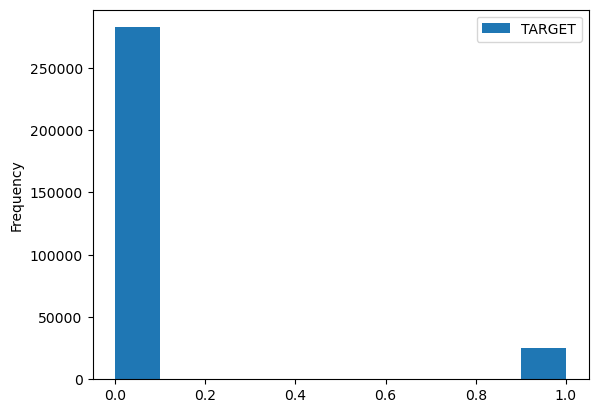

In [9]:
data_app_train_parquet.select('TARGET').toPandas().astype(int).plot.hist()

Từ thông tin này, chúng ta thấy đây là vấn đề mất cân bằng giai cấp. Có nhiều khoản vay được hoàn trả đúng hạn hơn các khoản vay không được hoàn trả. Khi chúng ta tiếp cận các mô hình học máy phức tạp hơn, chúng ta có thể đánh giá các lớp bằng cách thể hiện chúng trong dữ liệu để phản ánh sự mất cân bằng này.

# Kiểm tra các giá trị bị thiếu

Tiếp theo chúng ta có thể xem số lượng và phần trăm giá trị còn thiếu trong mỗi cột.

In [10]:
from pyspark.sql.functions import col
import pandas as pd
def missing_values_table_spark(df):
    # List of columns
    columns = df.columns
    
    # Dictionary to store missing values information
    missing_info = {'Columns': [], 'Missing Values': [], '% of Total Values': []}
    
    # Loop through each column
    for col_name in columns:
        # Count missing values in the column
        missing_count = df.where(col(col_name).isNull()).count()
        
        # Calculate percentage of missing values
        missing_percent = (missing_count / df.count()) * 100
        
        # Add information to the dictionary
        missing_info['Columns'].append(col_name)
        missing_info['Missing Values'].append(missing_count)
        missing_info['% of Total Values'].append(missing_percent)
    
    # Convert dictionary to DataFrame
    missing_df = spark.createDataFrame(pd.DataFrame(missing_info))
    
    # Sort DataFrame by % of Total Values descending
    missing_df = missing_df.orderBy('% of Total Values', ascending=False)
    
    # Print summary information
    print("Your selected dataframe has {} columns.".format(len(columns)))
    print("There are {} columns that have missing values.".format(missing_df.count()))
    
    # Return DataFrame with missing information
    return missing_df

In [11]:
# Calculate missing values statistics
missing_values_spark = missing_values_table_spark(data_app_train_parquet)
missing_values_spark.show()

Your selected dataframe has 122 columns.
There are 122 columns that have missing values.
+--------------------+--------------+------------------+
|             Columns|Missing Values| % of Total Values|
+--------------------+--------------+------------------+
|     COMMONAREA_MODE|        214865| 69.87229725115525|
|      COMMONAREA_AVG|        214865| 69.87229725115525|
|     COMMONAREA_MEDI|        214865| 69.87229725115525|
|NONLIVINGAPARTMEN...|        213514| 69.43296337366793|
|NONLIVINGAPARTMEN...|        213514| 69.43296337366793|
|NONLIVINGAPARTMEN...|        213514| 69.43296337366793|
|  FONDKAPREMONT_MODE|        210295| 68.38617155158677|
|LIVINGAPARTMENTS_...|        210199| 68.35495315614726|
|LIVINGAPARTMENTS_AVG|        210199| 68.35495315614726|
|LIVINGAPARTMENTS_...|        210199| 68.35495315614726|
|       FLOORSMIN_AVG|        208642| 67.84862980511267|
|      FLOORSMIN_MODE|        208642| 67.84862980511267|
|      FLOORSMIN_MEDI|        208642| 67.84862980511267|

Khi đến lúc xây dựng các mô hình học máy, chúng ta sẽ phải điền vào các giá trị còn thiếu này (được gọi là quy định). Trong công việc sau này, chúng tôi sẽ sử dụng các mô hình như XGBoost có thể xử lý các giá trị bị thiếu mà không cần phải xác định. Một tùy chọn khác là loại bỏ các cột có tỷ lệ giá trị bị thiếu cao, mặc dù không thể biết trước liệu các cột này có hữu ích cho mô hình của chúng tôi hay không. Vì vậy, bây giờ chúng tôi sẽ giữ tất cả các cột.

# Các loại cột

Hãy xem số lượng cột của từng loại dữ liệu. int64 và float64 là các biến số (có thể rời rạc hoặc liên tục). các cột đối tượng chứa các chuỗi và là các tính năng phân loại. .

In [12]:
from pyspark.sql import DataFrame

def count_column_types(df: DataFrame):
    # Lấy các cặp (tên cột, kiểu dữ liệu) và đếm số lượng mỗi kiểu dữ liệu
    type_counts = {}
    for column_type in df.dtypes:
        col_type = column_type[1]  # Lấy kiểu dữ liệu của cột
        if col_type in type_counts:
            type_counts[col_type] += 1
        else:
            type_counts[col_type] = 1
    return type_counts

# Áp dụng hàm trên DataFrame của bạn
column_type_counts = count_column_types(data_app_train_parquet)

# In kết quả
for dtype, count in column_type_counts.items():
    print(f"Type {dtype}: {count} columns")


Type int: 41 columns
Type string: 16 columns
Type double: 65 columns


Bây giờ chúng ta hãy xem số lượng mục duy nhất trong mỗi cột string.

In [13]:
# Number of unique classes in each object column
unique_classes = {}
object_columns = [col_name for col_name, col_dtype in data_app_train_parquet.dtypes if col_dtype == "string"]
for col_name in object_columns:
    unique_classes[col_name] = data_app_train_parquet.select(col_name).distinct().count()

# Print the number of unique classes in each object column
for col_name, unique_count in unique_classes.items():
    print("Number of unique classes in column '{}': {}".format(col_name, unique_count))

Number of unique classes in column 'NAME_CONTRACT_TYPE': 2
Number of unique classes in column 'CODE_GENDER': 3
Number of unique classes in column 'FLAG_OWN_CAR': 2
Number of unique classes in column 'FLAG_OWN_REALTY': 2
Number of unique classes in column 'NAME_TYPE_SUITE': 8
Number of unique classes in column 'NAME_INCOME_TYPE': 8
Number of unique classes in column 'NAME_EDUCATION_TYPE': 5
Number of unique classes in column 'NAME_FAMILY_STATUS': 6
Number of unique classes in column 'NAME_HOUSING_TYPE': 6
Number of unique classes in column 'OCCUPATION_TYPE': 19
Number of unique classes in column 'WEEKDAY_APPR_PROCESS_START': 7
Number of unique classes in column 'ORGANIZATION_TYPE': 58
Number of unique classes in column 'FONDKAPREMONT_MODE': 5
Number of unique classes in column 'HOUSETYPE_MODE': 4
Number of unique classes in column 'WALLSMATERIAL_MODE': 8
Number of unique classes in column 'EMERGENCYSTATE_MODE': 3


Hầu hết các biến phân loại có số lượng mục duy nhất tương đối nhỏ. Chúng ta sẽ cần tìm cách đối phó với những biến số phân loại này!

# Encoding Categorical Variables

Label Encoding and One-Hot Encoding

In [14]:
from pyspark.sql.types import StringType
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

# Danh sách để lưu các stages của Pipeline
stages = []

# Duyệt qua từng cột trong DataFrame
for col_name in data_app_train_parquet.columns:
    if data_app_train_parquet.schema[col_name].dataType == StringType():
        # Tạo StringIndexer để chuyển chuỗi thành số
        indexer = StringIndexer(inputCol=col_name, outputCol=col_name + "_index", handleInvalid="skip")
        # Tạo OneHotEncoder để thực hiện one-hot encoding cho các chỉ số
        encoder = OneHotEncoder(inputCols=[col_name + "_index"], outputCols=[col_name + "_encoded"])
        
        # Thêm indexer và encoder vào danh sách các stages
        stages += [indexer, encoder]

# Tạo và thực thi Pipeline
pipeline = Pipeline(stages=stages)
pipeline_model = pipeline.fit(data_app_train_parquet)
app_train_encoded = pipeline_model.transform(data_app_train_parquet)
app_test_encoded = pipeline_model.transform(data_app_test_parquet)


In [15]:
# In ra kích thước của dữ liệu sau khi đã thực hiện encoding
print('Training Features shape: ', app_train_encoded.count(), len(app_train_encoded.columns))
print('Testing Features shape: ', app_test_encoded.count(), len(app_test_encoded.columns))

Training Features shape:  65789 154
Testing Features shape:  10468 153


Aligning Training and Testing Data

In [16]:
from pyspark.sql.functions import col
# Lấy ra cột TARGET và SK_ID_CURR trước khi xóa TARGET khỏi bộ dữ liệu huấn luyện
train_labels = data_app_train_parquet.select("TARGET", "SK_ID_CURR")

# Lấy ra các cột chung giữa hai DataFrame
common_columns = set(data_app_train_parquet.columns).intersection(set(data_app_test_parquet.columns))

# Chọn các cột chung từ bộ dữ liệu huấn luyện và kiểm tra
common_train = data_app_train_parquet.select(*common_columns)
common_test = data_app_test_parquet.select(*common_columns)

# Thêm cột TARGET trở lại vào bộ dữ liệu huấn luyện bằng cách join với train_labels
common_train = common_train.join(train_labels, "SK_ID_CURR")

# In kích thước của bộ dữ liệu sau khi căn chỉnh
print('Training Features shape: ', common_train.count(), len(common_train.columns))
print('Testing Features shape: ', common_test.count(), len(common_test.columns))

Training Features shape:  307511 122
Testing Features shape:  48744 121


# Back to Exploratory Data Analysis

Sự bất thường

Một vấn đề mà chúng tôi luôn muốn lưu ý khi thực hiện EDA là những điểm bất thường trong dữ liệu. Những điều này có thể là do gõ sai số, lỗi trong thiết bị đo hoặc có thể là số đo hợp lệ nhưng cực đoan. Một cách để hỗ trợ các điểm bất thường về mặt định lượng là xem số liệu thống kê của một cột bằng phương pháp mô tả. Các số trong cột DAYS_BIRTH là số âm vì chúng được ghi lại có liên quan đến đơn xin vay hiện tại. Để xem các số liệu thống kê này theo năm, chúng ta có thể nhân với -1 và chia cho số ngày trong một năm:

In [17]:
from pyspark.sql.functions import col, expr
from pyspark.sql.types import DoubleType

# Chuyển đổi cột DAYS_BIRTH thành tuổi (đơn vị là năm)
app_train_spark = data_app_train_parquet.withColumn("AGE", expr("- DAYS_BIRTH / 365").cast(DoubleType()))

# Tính toán mô tả thống kê
age_stats = app_train_spark.select("AGE").describe()

# Hiển thị kết quả
age_stats.show()

+-------+------------------+
|summary|               AGE|
+-------+------------------+
|  count|            307511|
|   mean|43.936972785871575|
| stddev|11.956133237768656|
|    min|20.517808219178082|
|    max| 69.12054794520547|
+-------+------------------+



Những độ tuổi đó có vẻ hợp lý. Không có ngoại lệ nào cho độ tuổi ở cấp cao hay cấp thấp. Còn những ngày làm việc thì sao?

In [18]:
# Chuyển đổi cột DAYS_EMPLOYED thành số dương để biểu diễn thời gian làm việc dương tính (tính theo ngày)
app_train_spark = data_app_train_parquet.withColumn("DAYS_EMPLOYED_POSITIVE", expr("- DAYS_EMPLOYED").cast(DoubleType()))

# Tính toán mô tả thống kê
days_employed_stats = app_train_spark.select("DAYS_EMPLOYED_POSITIVE").describe()

# Hiển thị kết quả
days_employed_stats.show()

+-------+----------------------+
|summary|DAYS_EMPLOYED_POSITIVE|
+-------+----------------------+
|  count|                307511|
|   mean|    -63815.04590404896|
| stddev|    141275.76651872727|
|    min|             -365243.0|
|    max|               17912.0|
+-------+----------------------+



Điều đó có vẻ không đúng! Giá trị tối đa (ngoài giá trị dương) là khoảng 1000 năm!

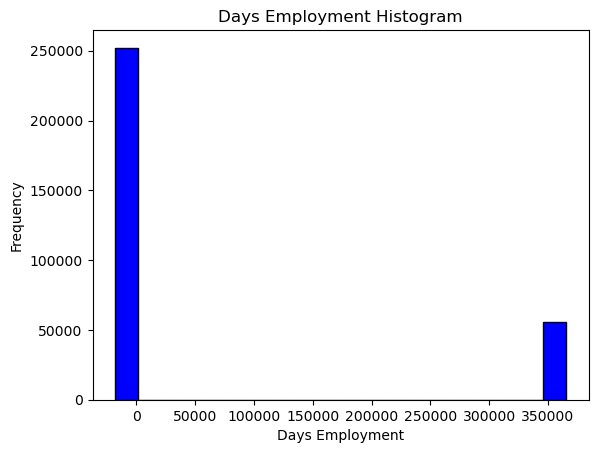

In [19]:
import matplotlib.pyplot as plt

# Chuyển đổi DataFrame PySpark thành Pandas DataFrame
app_train_pd = data_app_train_parquet.select("DAYS_EMPLOYED").toPandas()

# Vẽ biểu đồ histogram
plt.hist(app_train_pd['DAYS_EMPLOYED'], bins=20, color='blue', edgecolor='black')

# Đặt tiêu đề và tên trục
plt.title('Days Employment Histogram')
plt.xlabel('Days Employment')
plt.ylabel('Frequency')

# Hiển thị biểu đồ
plt.show()

Vì tò mò, chúng ta hãy phân nhóm các khách hàng bất thường và xem liệu họ có xu hướng có tỷ lệ vỡ nợ cao hơn hay thấp hơn các khách hàng còn lại.

In [20]:
from pyspark.sql import functions as F

# Lọc những dòng có giá trị DAYS_EMPLOYED bất thường và bình thường
anom = data_app_train_parquet.filter(data_app_train_parquet['DAYS_EMPLOYED'] == 365243)
non_anom = data_app_train_parquet.filter(data_app_train_parquet['DAYS_EMPLOYED'] != 365243)

# Tính tỷ lệ vỡ nợ cho nhóm không bất thường
non_anom_default_rate = non_anom.agg(F.mean('TARGET').alias('default_rate')).collect()[0]['default_rate'] * 100

# Tính tỷ lệ vỡ nợ cho nhóm bất thường
anom_default_rate = anom.agg(F.mean('TARGET').alias('default_rate')).collect()[0]['default_rate'] * 100

# Đếm số lượng bất thường
anom_count = anom.count()

# In kết quả
print('The non-anomalies default on %0.2f%% of loans' % non_anom_default_rate)
print('The anomalies default on %0.2f%% of loans' % anom_default_rate)
print('There are %d anomalous days of employment' % anom_count)


The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


Hóa ra những điều bất thường có tỷ lệ vỡ nợ thấp hơn.

Việc xử lý các hiện tượng bất thường phụ thuộc vào tình huống cụ thể, không có quy tắc nào được đặt ra. Một trong những cách tiếp cận an toàn nhất chỉ là đặt các điểm bất thường thành một giá trị còn thiếu và sau đó điền chúng vào (sử dụng Phép tính) trước khi học máy. Trong trường hợp này, vì tất cả các điểm bất thường đều có cùng một giá trị, nên chúng tôi muốn điền chúng với cùng một giá trị trong trường hợp tất cả các khoản vay này có chung điểm chung. Các giá trị dị thường dường như có một số tầm quan trọng, vì vậy chúng tôi muốn cho mô hình học máy biết liệu trên thực tế chúng tôi có điền vào các giá trị này hay không. Để giải quyết, chúng tôi sẽ điền vào các giá trị dị thường không phải số (np.nan) rồi tạo một cột boolean mới cho biết giá trị đó có bất thường hay không.

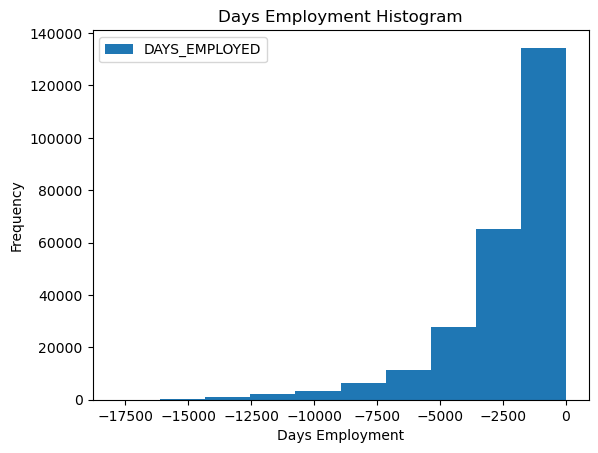

In [21]:
from pyspark.sql import functions as F
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

# Tạo cột cờ bất thường
data_app_train_parquet = data_app_train_parquet.withColumn('DAYS_EMPLOYED_ANOM', (col('DAYS_EMPLOYED') == 365243))

# Thay thế các giá trị bất thường bằng None (tương đương với NaN trong pandas)
data_app_train_parquet = data_app_train_parquet.withColumn('DAYS_EMPLOYED', F.when(col('DAYS_EMPLOYED') == 365243, None).otherwise(col('DAYS_EMPLOYED')))

# Vẽ biểu đồ histogram
# Bước này yêu cầu chuyển đổi dữ liệu sang Pandas trước khi vẽ, nên lưu ý về hiệu năng khi làm việc với bộ dữ liệu lớn
pandas_df = data_app_train_parquet.select('DAYS_EMPLOYED').toPandas()
pandas_df.plot.hist(title='Days Employment Histogram')
plt.xlabel('Days Employment')
plt.show()


Sự phân bổ có vẻ phù hợp hơn nhiều với những gì chúng tôi mong đợi và chúng tôi cũng đã tạo một cột mới để cho mô hình biết rằng các giá trị này ban đầu là bất thường (vì chúng tôi sẽ phải điền vào các nans một số giá trị, có thể là giá trị trung bình). của cột). Các cột khác có DAYS trong khung dữ liệu trông giống như những gì chúng tôi mong đợi và không có ngoại lệ rõ ràng.

Một lưu ý cực kỳ quan trọng, bất cứ điều gì chúng ta làm với dữ liệu huấn luyện, chúng ta cũng phải làm với dữ liệu thử nghiệm. Hãy đảm bảo tạo cột mới và điền vào cột hiện có np.nan trong dữ liệu thử nghiệm.

In [22]:
from pyspark.sql import functions as F
from pyspark.sql.functions import col, when

# Tạo cột cờ bất thường
data_app_test_parquet = data_app_test_parquet.withColumn(
    'DAYS_EMPLOYED_ANOM', 
    (col('DAYS_EMPLOYED') == 365243)
)

# Thay thế các giá trị bất thường bằng None (tương đương với NaN trong pandas)
data_app_test_parquet = data_app_test_parquet.withColumn(
    'DAYS_EMPLOYED', 
    when(col('DAYS_EMPLOYED') == 365243, None).otherwise(col('DAYS_EMPLOYED'))
)

# Đếm số lượng anomalies
anomalies_count = data_app_test_parquet.filter(col('DAYS_EMPLOYED_ANOM')).count()
total_entries = data_app_test_parquet.count()

print('There are %d anomalies in the test data out of %d entries' % (anomalies_count, total_entries))


There are 9274 anomalies in the test data out of 48744 entries


Tương quan

Bây giờ chúng ta đã xử lý xong các biến phân loại và các giá trị ngoại lệ, hãy tiếp tục với EDA. Một cách để thử và hiểu dữ liệu là tìm kiếm mối tương quan giữa các tính năng và mục tiêu. Chúng ta có thể tính hệ số tương quan Pearson giữa mọi biến và mục tiêu bằng phương pháp khung dữ liệu .corr.

Hệ số tương quan không phải là phương pháp tốt nhất để thể hiện "mức độ liên quan" của một tính năng, nhưng nó cho chúng ta ý tưởng về các mối quan hệ có thể có trong dữ liệu. Một số cách giải thích chung về giá trị tuyệt đối của hệ số tương quan là:

- 0,00-0,19 “rất yếu”
- 0,20-0,39 “yếu”
- 0,40-0,59 “vừa phải”
- 0,60-0,79 “mạnh”
- .80-1.0 “rất mạnh”

In [23]:
from pyspark.sql.functions import col
from pyspark.sql.types import BooleanType

# Chuyển đổi tất cả các cột boolean thành integer
for column in data_app_train_parquet.columns:
    if isinstance(data_app_train_parquet.schema[column].dataType, BooleanType):
        data_app_train_parquet = data_app_train_parquet.withColumn(column, col(column).cast("integer"))

# Lấy danh sách các cột có kiểu dữ liệu số, bỏ qua cột TARGET
numeric_features = [t[0] for t in data_app_train_parquet.dtypes if t[1] != 'string' and t[0] != 'TARGET']

# Dictionary để lưu trữ hệ số tương quan
correlation_dict = {}

for column in numeric_features:
    correlation = data_app_train_parquet.stat.corr('TARGET', column)
    if correlation is not None:  # Kiểm tra để loại bỏ trường hợp không thể tính được tương quan
        correlation_dict[column] = correlation

# Chuyển dictionary thành một list của tuples và sắp xếp nó
sorted_correlations = sorted(correlation_dict.items(), key=lambda x: x[1], reverse=True)

# Hiển thị 15 tương quan tích cực nhất và 15 tương quan tiêu cực nhất
print('Most Positive Correlations:\n', sorted_correlations[:15])
print('\nMost Negative Correlations:\n', sorted_correlations[-15:])


Most Positive Correlations:
 [('DAYS_BIRTH', 0.07823930830982692), ('REGION_RATING_CLIENT_W_CITY', 0.0608926675648235), ('REGION_RATING_CLIENT', 0.058899014945712494), ('DAYS_LAST_PHONE_CHANGE', 0.05521723161673529), ('DAYS_ID_PUBLISH', 0.051457172607057435), ('REG_CITY_NOT_WORK_CITY', 0.05099446436812653), ('DAYS_EMPLOYED', 0.04605222069918203), ('FLAG_EMP_PHONE', 0.045982219716592554), ('REG_CITY_NOT_LIVE_CITY', 0.04439537480570084), ('FLAG_DOCUMENT_3', 0.044346346851145024), ('DAYS_REGISTRATION', 0.04197486283141711), ('LIVE_CITY_NOT_WORK_CITY', 0.032518341101498795), ('DEF_30_CNT_SOCIAL_CIRCLE', 0.0323942150845551), ('DEF_60_CNT_SOCIAL_CIRCLE', 0.03140052988503111), ('FLAG_WORK_PHONE', 0.028524322363217367)]

Most Negative Correlations:
 [('APARTMENTS_MEDI', -0.03971992715372325), ('APARTMENTS_AVG', -0.039923811524523345), ('LIVINGAREA_MEDI', -0.04012262525087342), ('LIVINGAREA_AVG', -0.040301107170409814), ('YEARS_BEGINEXPLUATATION_MODE', -0.040943597604212296), ('YEARS_BEGINEXPLU

Chúng ta hãy xem xét một số mối tương quan quan trọng hơn: DAYS_BIRTH là mối tương quan tích cực nhất. (ngoại trừ TARGET vì mối tương quan của một biến với chính nó luôn là 1!) Nhìn vào tài liệu, DAYS_BIRTH là tuổi tính theo ngày của khách hàng tại thời điểm vay, tính theo ngày âm (vì bất kỳ lý do gì!). Mối tương quan là dương, nhưng giá trị của đặc điểm này thực sự là âm, có nghĩa là khi khách hàng già đi, họ ít có khả năng vỡ nợ đối với khoản vay của mình (tức là mục tiêu == 0). Điều đó hơi khó hiểu, vì vậy chúng tôi sẽ lấy giá trị tuyệt đối của đặc điểm và khi đó mối tương quan sẽ âm.

Ảnh hưởng của tuổi đến việc trả nợ

In [24]:
from pyspark.sql.functions import abs, corr

# Chuyển các ngày sinh thành giá trị tuyệt đối
data_app_train_parquet = data_app_train_parquet.withColumn('DAYS_BIRTH', abs(data_app_train_parquet['DAYS_BIRTH']))

# Tính tương quan giữa DAYS_BIRTH và TARGET
correlation_days_birth_target = data_app_train_parquet.stat.corr('DAYS_BIRTH', 'TARGET')

print("Correlation between DAYS_BIRTH and TARGET:", correlation_days_birth_target)


Correlation between DAYS_BIRTH and TARGET: -0.07823930830982692


Khi khách hàng già đi, có mối quan hệ tuyến tính tiêu cực với mục tiêu, nghĩa là khi khách hàng già đi, họ có xu hướng trả nợ đúng hạn thường xuyên hơn.

Hãy bắt đầu xem xét biến này. Đầu tiên, chúng ta có thể tạo ra một biểu đồ về độ tuổi. Chúng ta sẽ đặt trục x theo năm để làm cho cốt truyện dễ hiểu hơn một chút.

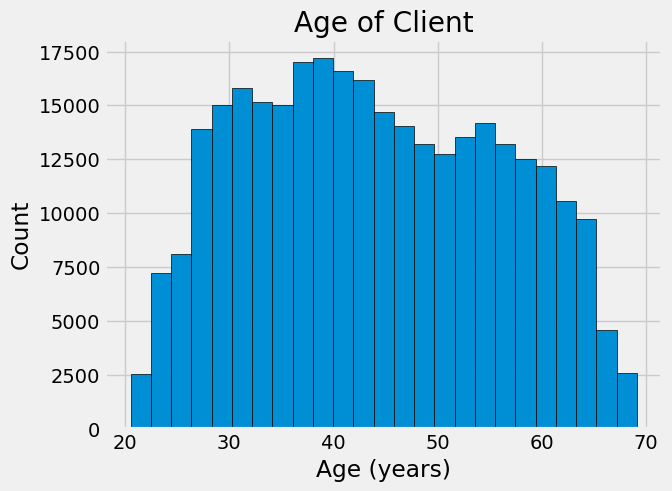

In [25]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

# Convert 'DAYS_BIRTH' from days to years and create a new column 'AGE_YEARS'
data_app_train_parquet = data_app_train_parquet.withColumn('AGE_YEARS', col('DAYS_BIRTH') / 365)

# Collect the data to local for plotting
age_data = data_app_train_parquet.select('AGE_YEARS').toPandas()

# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(age_data['AGE_YEARS'], edgecolor='k', bins=25)
plt.title('Age of Client')
plt.xlabel('Age (years)')
plt.ylabel('Count')
plt.show()


Bản thân sự phân bổ độ tuổi không cho chúng ta biết nhiều điều gì khác ngoài việc không có ngoại lệ vì mọi lứa tuổi đều hợp lý. Để hình dung ảnh hưởng của độ tuổi đối với mục tiêu, tiếp theo chúng ta sẽ tạo biểu đồ ước tính mật độ hạt nhân (KDE) được tô màu theo giá trị của mục tiêu. Biểu đồ ước tính mật độ hạt nhân cho thấy sự phân bố của một biến duy nhất và có thể được coi là biểu đồ được làm mịn (nó được tạo bằng cách tính toán một hạt nhân, thường là Gaussian, tại mỗi điểm dữ liệu và sau đó lấy trung bình tất cả các hạt nhân riêng lẻ để phát triển một hạt nhân mịn duy nhất). đường cong). Chúng tôi sẽ sử dụng kdeplot seaborn cho biểu đồ này.

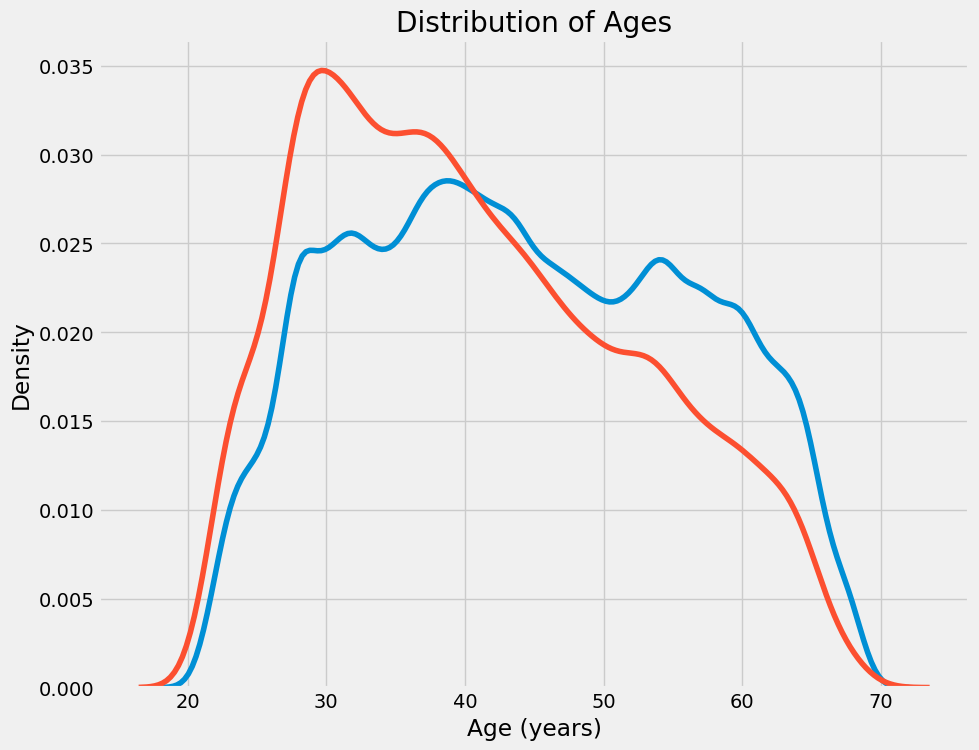

In [26]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import seaborn as sns

# Convert 'DAYS_BIRTH' from days to years and create a new column 'AGE_YEARS'
data_app_train_parquet = data_app_train_parquet.withColumn('AGE_YEARS', col('DAYS_BIRTH') / 365)

# Collect the required data for plotting to local
age_data_repaid = data_app_train_parquet.filter(col('TARGET') == 0).select('AGE_YEARS').toPandas()
age_data_not_repaid = data_app_train_parquet.filter(col('TARGET') == 1).select('AGE_YEARS').toPandas()

# Set the figure size
plt.figure(figsize=(10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(age_data_repaid['AGE_YEARS'], label='target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(age_data_not_repaid['AGE_YEARS'], label='target == 1')

# Labeling of plot
plt.xlabel('Age (years)')
plt.ylabel('Density')
plt.title('Distribution of Ages')
plt.show()


Đường cong mục tiêu == 1 nghiêng về phía đầu trẻ hơn của phạm vi. Mặc dù đây không phải là mối tương quan đáng kể (hệ số tương quan -0,07), biến này có thể sẽ hữu ích trong mô hình học máy vì nó ảnh hưởng đến mục tiêu. Hãy nhìn mối quan hệ này theo một cách khác: khả năng không trả được nợ trung bình theo độ tuổi.

Để tạo biểu đồ này, đầu tiên chúng tôi chia nhóm tuổi thành các nhóm 5 tuổi. Sau đó, đối với mỗi thùng, chúng tôi tính toán giá trị trung bình của mục tiêu, giá trị này cho chúng tôi biết tỷ lệ các khoản vay chưa được hoàn trả ở từng nhóm tuổi.

Nguồn bên ngoài

3 biến có mối tương quan nghịch mạnh nhất với mục tiêu là EXT_SOURCE_1, EXT_SOURCE_2 và EXT_SOURCE_3. Theo tài liệu, các tính năng này thể hiện "điểm chuẩn hóa từ nguồn dữ liệu bên ngoài". Tôi không chắc điều này chính xác có nghĩa là gì, nhưng nó có thể là một loại xếp hạng tín dụng tích lũy được thực hiện bằng cách sử dụng nhiều nguồn dữ liệu.

Chúng ta hãy xem xét các biến này.

Đầu tiên, chúng ta có thể hiển thị mối tương quan của các tính năng EXT_SOURCE với mục tiêu và với nhau.

In [30]:
# List of columns to calculate correlation
columns = ['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']

# Initialize a list to collect correlation results
correlation_results = []

# Calculate pairwise correlations
for col1 in columns:
    for col2 in columns:
        if col1 != col2:
            correlation = data_app_train_parquet.stat.corr(col1, col2)
            correlation_results.append((col1, col2, correlation))

# Create a DataFrame to view the correlations
correlation_df = spark.createDataFrame(correlation_results, ["Column1", "Column2", "Correlation"])

# Show the DataFrame
correlation_df.show()


+------------+------------+--------------------+
|     Column1|     Column2|         Correlation|
+------------+------------+--------------------+
|      TARGET|EXT_SOURCE_1| -0.0646981333359047|
|      TARGET|EXT_SOURCE_2|-0.15902967651017422|
|      TARGET|EXT_SOURCE_3| -0.1195719284871247|
|      TARGET|  DAYS_BIRTH|-0.07823930830982692|
|EXT_SOURCE_1|      TARGET| -0.0646981333359047|
|EXT_SOURCE_1|EXT_SOURCE_2| 0.11408250428195794|
|EXT_SOURCE_1|EXT_SOURCE_3|0.040438058943102866|
|EXT_SOURCE_1|  DAYS_BIRTH|-0.05907316494179...|
|EXT_SOURCE_2|      TARGET|-0.15902967651017422|
|EXT_SOURCE_2|EXT_SOURCE_1| 0.11408250428195792|
|EXT_SOURCE_2|EXT_SOURCE_3| 0.09666534608006253|
|EXT_SOURCE_2|  DAYS_BIRTH|  0.0904872187139796|
|EXT_SOURCE_3|      TARGET|-0.11957192848712468|
|EXT_SOURCE_3|EXT_SOURCE_1| 0.04043805894310286|
|EXT_SOURCE_3|EXT_SOURCE_2| 0.09666534608006254|
|EXT_SOURCE_3|  DAYS_BIRTH|  0.1512196896933838|
|  DAYS_BIRTH|      TARGET|-0.07823930830982692|
|  DAYS_BIRTH|EXT_SO

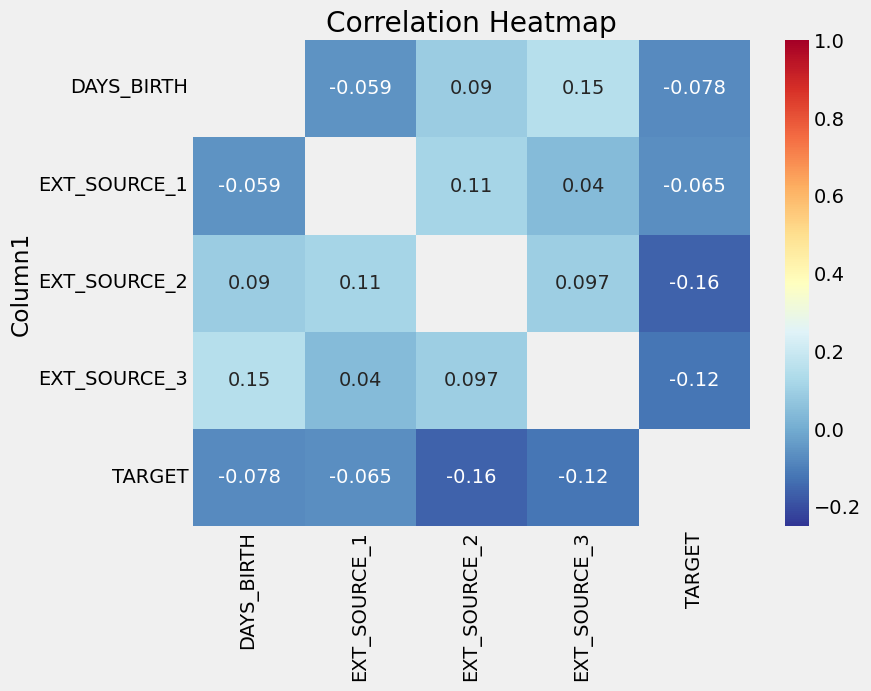

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Collect the Spark DataFrame to a Pandas DataFrame
correlation_pd = correlation_df.toPandas()

# Pivot the DataFrame to create a correlation matrix
correlation_matrix = correlation_pd.pivot(index='Column1', columns='Column2', values='Correlation')

# Since the matrix is only half-filled (no repeated or self correlations), mirror it to the other half
correlation_matrix = correlation_matrix.combine_first(correlation_matrix.T)

# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Plot the heatmap
sns.heatmap(correlation_matrix, cmap='RdYlBu_r', annot=True, vmin=-0.25, vmax=1)

# Add title
plt.title('Correlation Heatmap')

# Show plot
plt.show()


Tất cả ba đặc điểm EXT_SOURCE đều có mối tương quan nghịch với mục tiêu, cho thấy rằng khi giá trị của EXT_SOURCE tăng lên, khách hàng có nhiều khả năng hoàn trả khoản vay hơn. Chúng ta cũng có thể thấy rằng DAYS_BIRTH có mối tương quan thuận với EXT_SOURCE_1 cho thấy rằng có thể một trong các yếu tố trong điểm số này là độ tuổi của khách hàng.

# Chuẩn hóa dữ liệu

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, Imputer
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.functions import col
# Assuming data_app_train is your Spark DataFrame
data = data_app_train_parquet.drop('SK_ID_CURR')

# Rename 'TARGET' to 'label'
data = data.withColumnRenamed('TARGET', 'label')

# Handling null values for categorical and numeric columns
categorical_columns = [t[0] for t in data.dtypes if t[1] == 'string']
numerical_columns = [t[0] for t in data.dtypes if t[1] != 'string' and t[0] != 'label']

# Fill missing values for categorical and numerical data
data = data.fillna('unknown', subset=categorical_columns)
data = data.fillna(0, subset=numerical_columns)

# Index and encode categorical columns
indexers = [StringIndexer(inputCol=c, outputCol=f"{c}_indexed", handleInvalid='keep') for c in categorical_columns]
encoders = [OneHotEncoder(inputCol=indexer.getOutputCol(), outputCol=f"{indexer.getOutputCol()}_encoded") for indexer in indexers]

# Assemble all the features together
assembler_inputs = [encoder.getOutputCol() for encoder in encoders] + numerical_columns
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")

# Chia dữ liệu

In [ ]:
# Split the data into training and test sets
(train_data, test_data) = data.randomSplit([0.8, 0.2], seed=1234)

# Logistic Regression 

In [40]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
# Define the Logistic Regression model
lr = LogisticRegression(featuresCol="features", labelCol="label")

# Create the pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler, lr])

In [101]:
# Fit the model
model_lgt = pipeline.fit(train_data)
model_lgt.write().overwrite().save("model_lgt")
# Make predictions
predictions = model_lgt.transform(test_data)

Đánh giá

In [44]:
from pyspark.mllib.evaluation import MulticlassMetrics
# Evaluate the model
binary_evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
multi_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
# Compute metrics
roc_auc = binary_evaluator.evaluate(predictions)
accuracy = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "accuracy"})
f1 = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "f1"})
precision = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "weightedPrecision"})
recall = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "weightedRecall"})

# Confusion matrix
prediction_and_labels = predictions.select("prediction", "label").rdd.map(lambda row: (float(row["prediction"]), float(row["label"])))
metrics = MulticlassMetrics(prediction_and_labels)
confusion_matrix = metrics.confusionMatrix()

print("ROC AUC:", roc_auc)
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Confusion Matrix:\n", confusion_matrix)

/usr/local/spark/python/pyspark/sql/context.py:159: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning,


ROC AUC: 0.7287505145891191
Accuracy: 0.9202280590614492
F1 Score: 0.8824551656431965
Precision: 0.8719500140698039
Recall: 0.9202280590614492
Confusion Matrix:
 DenseMatrix([[5.6643e+04, 2.0000e+01],
             [4.8910e+03, 9.0000e+00]])


# Random Foresst

In [102]:
from pyspark.ml.classification import RandomForestClassifier
# Define the Random Forest model
rf = RandomForestClassifier(featuresCol="features", labelCol="label")

# Create the pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler, rf])
# Fit the model
model_rf = pipeline.fit(train_data)
model_rf.write().overwrite().save("model_rf")
# Make predictions
predictions = model_rf.transform(test_data)

Đánh giá

In [46]:
# Evaluate the model
binary_evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
multi_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
# Compute metrics
roc_auc = binary_evaluator.evaluate(predictions)
accuracy = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "accuracy"})
f1 = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "f1"})
precision = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "weightedPrecision"})
recall = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "weightedRecall"})

# Confusion matrix
prediction_and_labels = predictions.select("prediction", "label").rdd.map(lambda row: (float(row["prediction"]), float(row["label"])))
metrics = MulticlassMetrics(prediction_and_labels)
confusion_matrix = metrics.confusionMatrix()

print("ROC AUC:", roc_auc)
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Confusion Matrix:\n", confusion_matrix)

ROC AUC: 0.6794718487786903
Accuracy: 0.920406737813297
F1 Score: 0.8822595196439844
Precision: 0.8471485630121152
Recall: 0.920406737813297
Confusion Matrix:
 DenseMatrix([[56663.,     0.],
             [ 4900.,     0.]])
